# 残差网络（ResNet）
:label:`sec_resnet`

随着我们设计越来越深的网络，深刻理解“新添加的层如何提升神经网络的性能”变得至关重要。更重要的是设计网络的能力，在这种网络中，添加层会使网络更具表现力，
为了取得质的突破，我们需要一些数学基础知识。

## 函数类

首先，假设有一类特定的神经网络架构$\mathcal{F}$，它包括学习速率和其他超参数设置。
对于所有$f \in \mathcal{F}$，存在一些参数集（例如权重和偏置），这些参数可以通过在合适的数据集上进行训练而获得。
现在假设$f^*$是我们真正想要找到的函数，如果是$f^* \in \mathcal{F}$，那我们可以轻而易举的训练得到它，但通常我们不会那么幸运。
相反，我们将尝试找到一个函数$f^*_\mathcal{F}$，这是我们在$\mathcal{F}$中的最佳选择。
例如，给定一个具有$\mathbf{X}$特性和$\mathbf{y}$标签的数据集，我们可以尝试通过解决以下优化问题来找到它：

$$f^*_\mathcal{F} := \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \text{ subject to } f \in \mathcal{F}.$$

那么，怎样得到更近似真正$f^*$的函数呢？
唯一合理的可能性是，我们需要设计一个更强大的架构$\mathcal{F}'$。
换句话说，我们预计$f^*_{\mathcal{F}'}$比$f^*_{\mathcal{F}}$“更近似”。
然而，如果$\mathcal{F} \not\subseteq \mathcal{F}'$，则无法保证新的体系“更近似”。
事实上，$f^*_{\mathcal{F}'}$可能更糟：
如 :numref:`fig_functionclasses`所示，对于非嵌套函数（non-nested function）类，较复杂的函数类并不总是向“真”函数$f^*$靠拢（复杂度由$\mathcal{F}_1$向$\mathcal{F}_6$递增）。
在 :numref:`fig_functionclasses`的左边，虽然$\mathcal{F}_3$比$\mathcal{F}_1$更接近$f^*$，但$\mathcal{F}_6$却离的更远了。
相反对于 :numref:`fig_functionclasses`右侧的嵌套函数（nested function）类$\mathcal{F}_1 \subseteq \ldots \subseteq \mathcal{F}_6$，我们可以避免上述问题。

![对于非嵌套函数类，较复杂（由较大区域表示）的函数类不能保证更接近“真”函数（ $f^*$ ）。这种现象在嵌套函数类中不会发生。](../img/functionclasses.svg)
:label:`fig_functionclasses`

因此，只有当较复杂的函数类包含较小的函数类时，我们才能确保提高它们的性能。
对于深度神经网络，如果我们能将新添加的层训练成*恒等映射*（identity function）$f(\mathbf{x}) = \mathbf{x}$，新模型和原模型将同样有效。
同时，由于新模型可能得出更优的解来拟合训练数据集，因此添加层似乎更容易降低训练误差。

针对这一问题，何恺明等人提出了*残差网络*（ResNet） :cite:`He.Zhang.Ren.ea.2016`。
它在2015年的ImageNet图像识别挑战赛夺魁，并深刻影响了后来的深度神经网络的设计。
残差网络的核心思想是：每个附加层都应该更容易地包含原始函数作为其元素之一。
于是，*残差块*（residual blocks）便诞生了，这个设计对如何建立深层神经网络产生了深远的影响。
凭借它，ResNet赢得了2015年ImageNet大规模视觉识别挑战赛。

## (**残差块**)

让我们聚焦于神经网络局部：如图 :numref:`fig_residual_block`所示，假设我们的原始输入为$x$，而希望学出的理想映射为$f(\mathbf{x})$（作为 :numref:`fig_residual_block`上方激活函数的输入）。
 :numref:`fig_residual_block`左图虚线框中的部分需要直接拟合出该映射$f(\mathbf{x})$，而右图虚线框中的部分则需要拟合出残差映射$f(\mathbf{x}) - \mathbf{x}$。
残差映射在现实中往往更容易优化。
以本节开头提到的恒等映射作为我们希望学出的理想映射$f(\mathbf{x})$，我们只需将 :numref:`fig_residual_block`中右图虚线框内上方的加权运算（如仿射）的权重和偏置参数设成0，那么$f(\mathbf{x})$即为恒等映射。
实际中，当理想映射$f(\mathbf{x})$极接近于恒等映射时，残差映射也易于捕捉恒等映射的细微波动。
 :numref:`fig_residual_block`右图是ResNet的基础架构--*残差块*（residual block）。
在残差块中，输入可通过跨层数据线路更快地向前传播。

![一个正常块（左图）和一个残差块（右图）。](../img/residual-block.svg)
:label:`fig_residual_block`

ResNet沿用了VGG完整的$3\times 3$卷积层设计。
残差块里首先有2个有相同输出通道数的$3\times 3$卷积层。
每个卷积层后接一个批量规范化层和ReLU激活函数。
然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前。
这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加。
如果想改变通道数，就需要引入一个额外的$1\times 1$卷积层来将输入变换成需要的形状后再做相加运算。
残差块的实现如下：


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

如图 :numref:`fig_resnet_block`所示，此代码生成两种类型的网络：
一种是在`use_1x1conv=False`、应用ReLU非线性函数之前，将输入添加到输出。
另一种是在`use_1x1conv=True`时，添加通过$1 \times 1$卷积调整通道和分辨率。

![包含以及不包含 $1 \times 1$ 卷积层的残差块。](../img/resnet-block.svg)
:label:`fig_resnet_block`

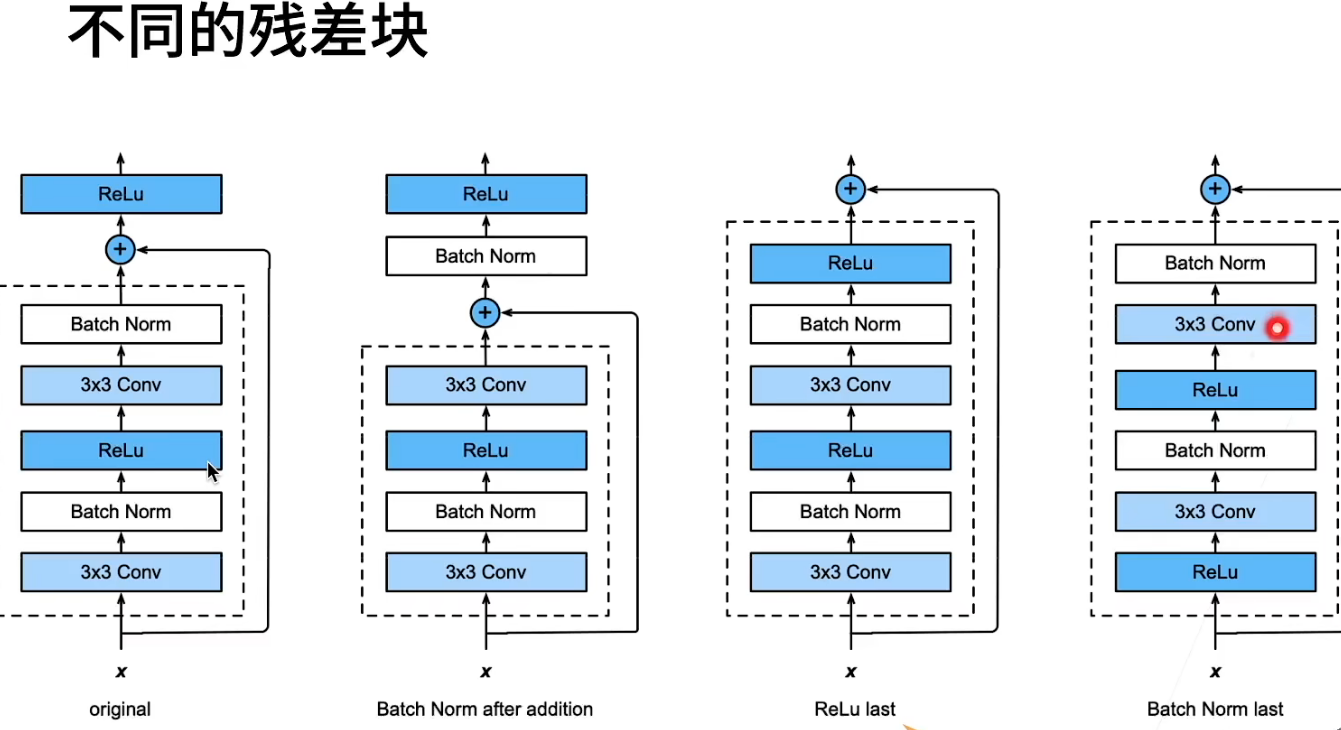
下面我们来查看[**输入和输出形状一致**]的情况。


In [2]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

我们也可以在[**增加输出通道数的同时，减半输出的高和宽**]。


In [3]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## [**ResNet模型**]

ResNet的前两层跟之前介绍的GoogLeNet中的一样：
在输出通道数为64、步幅为2的$7 \times 7$卷积层后，接步幅为2的$3 \times 3$的最大汇聚层。
不同之处在于ResNet每个卷积层后增加了批量规范化层。


In [4]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet在后面接了4个由Inception块组成的模块。
ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。
第一个模块的通道数同输入通道数一致。
由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。
之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

下面我们来实现这个模块。注意，我们对第一个模块做了特别处理。


In [5]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

接着在ResNet加入所有残差块，这里每个模块使用2个残差块。


In [6]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

最后，与GoogLeNet一样，在ResNet中加入全局平均汇聚层，以及全连接层输出。


In [7]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

每个模块有4个卷积层（不包括恒等映射的$1\times 1$卷积层）。
加上第一个$7\times 7$卷积层和最后一个全连接层，共有18层。
因此，这种模型通常被称为ResNet-18。
通过配置不同的通道数和模块里的残差块数可以得到不同的ResNet模型，例如更深的含152层的ResNet-152。
虽然ResNet的主体架构跟GoogLeNet类似，但ResNet架构更简单，修改也更方便。这些因素都导致了ResNet迅速被广泛使用。
 :numref:`fig_resnet18`描述了完整的ResNet-18。

![ResNet-18 架构](../img/resnet18.svg)
:label:`fig_resnet18`

在训练ResNet之前，让我们[**观察一下ResNet中不同模块的输入形状是如何变化的**]。
在之前所有架构中，分辨率降低，通道数量增加，直到全局平均汇聚层聚集所有特征。


In [8]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


## [**训练模型**]

同之前一样，我们在Fashion-MNIST数据集上训练ResNet。


loss 0.018, train acc 0.995, test acc 0.846
1517.8 examples/sec on cuda:0


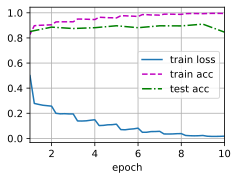

In [9]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* 学习嵌套函数（nested function）是训练神经网络的理想情况。在深层神经网络中，学习另一层作为恒等映射（identity function）较容易（尽管这是一个极端情况）。
* 残差映射可以更容易地学习同一函数，例如将权重层中的参数近似为零。
* 利用残差块（residual blocks）可以训练出一个有效的深层神经网络：输入可以通过层间的残余连接更快地向前传播。
* 残差网络（ResNet）对随后的深层神经网络设计产生了深远影响。

## 练习

1.  :numref:`fig_inception`中的Inception块与残差块之间的主要区别是什么？在删除了Inception块中的一些路径之后，它们是如何相互关联的？
1. 参考ResNet论文 :cite:`He.Zhang.Ren.ea.2016`中的表1，以实现不同的变体。
1. 对于更深层次的网络，ResNet引入了“bottleneck”架构来降低模型复杂性。请你试着去实现它。
1. 在ResNet的后续版本中，作者将“卷积层、批量规范化层和激活层”架构更改为“批量规范化层、激活层和卷积层”架构。请你做这个改进。详见 :cite:`He.Zhang.Ren.ea.2016*1`中的图1。
1. 为什么即使函数类是嵌套的，我们仍然要限制增加函数的复杂性呢？


1. 区别是有无将原始输入处理还是直接叠加

In [ ]:
#2. 
import torch
import torchvision
from torch import nn
from typing import List, Optional


class Bottleneck(nn.Module):
    # ResNet bottleneck block, 1x1conv-3x3conv-1x1conv.
    # downsample between stage layers to halve the size of input,
    # cooperated with 3x3conv stride=2

    # Normally the 3td conv possesses 4x channels compared to previous ones
    expansion = 4

    def __init__(self, in_channels, channels, stride=1, downsample: Optional[nn.Module]=None):
        super(Bottleneck, self).__init__()
        # Notice: In the first bottleneck of every residual stage,
        #         set 3x3conv stride=2 to halve the feature_map size,
        #         except the first residual stage (also named stage 2),
        #         which has been halved by MaxPooling with stirde=2 in stage 1.
        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=stride,
                            padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)
        self.conv3 = nn.Conv2d(channels, channels * self.expansion, kernel_size=1,
                            stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(channels *self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample == None:
            identity = x
        else:
            identity = self.downsample(x)

        out += identity # pixel-wise addtition
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    # Generic building func for ResNet-n
    def __init__(self, layers: List[int], num_classess=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.bottleneck = Bottleneck
        # The followling layers define stage 1(befor residual blocks)
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7,
                            stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # The following layers define stage 2-5(residual blocks)
        self.layer1 = self._make_layer(64, layers[0])
        self.layer2 = self._make_layer(128, layers[1], stride=2)
        self.layer3 = self._make_layer(256, layers[2], stride=2)
        self.layer4 = self._make_layer(512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.bottleneck.expansion, num_classess)

    # Build residual block
    def _make_layer(self, channels, num_bottleneck, stride=1):
        # 'stride' for 3x3conv or 1x1conv in downsample
        # channel=64 in first residual stage
        # stride=2 3x3conv & 1x1conv(downsmaple) in bottlenect 1 in in stage 2-5
        downsample = nn.Sequential(
            nn.Conv2d(self.in_channels, channels * self.bottleneck.expansion, 
                    kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(channels * self.bottleneck.expansion))
        layers = []
        # Append the first bottleneck of residual block
        layers.append(self.bottleneck(
            self.in_channels, channels, stride, downsample))
        # Append the rest bottlenecks of residual block
        self.in_channels *= self.bottleneck.expansion
        # For stage 3-5, in_channels is half of the out_channels of previous stage
        if channels != 64: # Indicate stage 3-5
            self.in_channels = int(self.in_channels / 2)
        for _ in range(1, num_bottleneck):
            layers.append(self.bottleneck(self.in_channels, channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Stage 1
        out = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        # Stage 2-5
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # GlobalAvgPool-FC
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

    # Construct ResNet-n
    def ResNet50(num_classess):
        return ResNet([3, 4, 6, 3], num_classess)

    def ResNet101(num_classess):
        return ResNet([3, 4, 23, 3], num_classess)

    def ResNet152(num_classess):
        return ResNet([3, 8, 36, 3], num_classess)

if __name__ == '__main__':
    num_classess = 1000
    # Build model structure
    resnet152 = ResNet.ResNet152(num_classess)
    # Load parameters from pretrained model
    pretraind_model_urls = {
        'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
        'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
        'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',}
    state_dict = torchvision.models.utils.load_state_dict_from_url(
        pretraind_model_urls['resnet152'],
        progress=True )
    resnet152 = resnet152.load_state_dict(state_dict)

4. 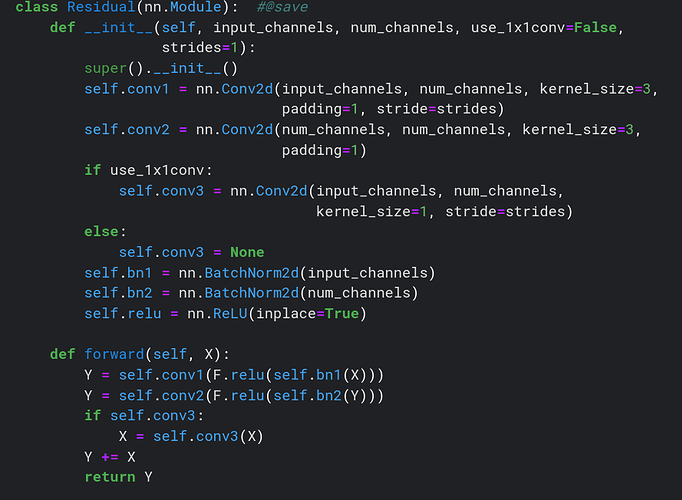